# Figure paper fake-training

In [ ]:
pip list

Package           Version   Editable project location
----------------- --------- ---------------------------------------
asttokens         2.0.5
astunparse        1.6.3
backcall          0.2.0
certifi           2022.12.7
colorama          0.4.6
comm              0.1.2
contourpy         1.0.7
cycler            0.11.0
debugpy           1.5.1
decorator         5.1.1
entrypoints       0.4
execnb            0.1.5
executing         0.8.3
fastcore          1.5.28
fonttools         4.38.0
ghapi             1.0.3
ipykernel         6.19.2
ipython           8.10.0
jedi              0.18.1
jupyter_client    7.4.9
jupyter_core      5.2.0
kiwisolver        1.4.4
matplotlib        3.7.0
matplotlib-inline 0.1.6
nbdev             2.3.12
nest-asyncio      1.5.6
numpy             1.24.2
packaging         22.0
parso             0.8.3
pickleshare       0.7.5
Pillow            9.4.0
pip               22.3.1
platformdirs      2.5.2
prompt-toolkit    3.0.36
psutil            5.9.0
pure-eval         0.2.2
Pyg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from rl_foraging.analytics import discrete_composite_sample, discrete_pw_sample, simul_2actions, get_ps_composite, get_ps

ModuleNotFoundError: No module named 'rl_foraging'

In [ ]:
def hex_rgb(value):
    """Return (red, green, blue) for the color given as #rrggbb."""
    value = value.lstrip('#')
    lv = len(value)
    return np.array(tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3)))/255

import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

list_color = [hex_rgb(i) for i in ['f9b233ff', '1d71b8ff']]
cmap_list = LinearSegmentedColormap.from_list("", list_color, N = 8)
def color(idx, cmap = cmap_list, num_c = 4):
    return cmap(np.linspace(0, 1, num_c)[idx])

font_legend = 10

In [ ]:
num_states = int(1e4)

# This one for good figure
epochs = int(1e3); num_steps = int(1e4);

# This one for draft:
#epochs = int(1e2); num_steps = int(1e2);

## Fig 2. 

Power law

In [ ]:
betas = [0.5, 1, 1.5, 2]
hmatrix_pw = np.zeros((len(betas), 2, num_states))

for idxb, beta in enumerate(tqdm(betas)):
    
    ps = simul_2actions(num_states = num_states,
                        eta = int(1e-7),
                        gamma = 0)
    
    steps = discrete_pw_sample(beta, L_max = num_states, num_samples = int(epochs*num_steps))
    steps = steps.reshape(epochs, num_steps)
                               
    for e in tqdm(range(epochs)):
        ps.reset()
        for s in steps[e]:    
            ps.reward(length = s)
            
    hmatrix_pw[idxb] = ps.h_matrix

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

BiExp

In [ ]:
probs = np.array([0.94, 0.06])
lambdas = np.array([0.6, 5000])

lambdas_1 = [0.6, 0.6*2, 0.6*8, 0.6*16]
hmatrix_bi = np.zeros((len(lambdas_1), num_states))

for idx_l, lambda_1 in enumerate(tqdm(lambdas_1)):
    
    ps = simul_2actions(num_states = num_states,
                    eta = int(1e-7),
                    gamma = 0)
    
    lambdas[0] = lambda_1
    steps = discrete_composite_sample(lambdas = lambdas,
                                      probs = probs, 
                                      L_max = num_states, num_samples = num_steps*epochs)
    steps = steps.reshape(epochs, num_steps)
    
    # Training
    for e in tqdm(range(epochs)):
        ps.reset()
        for s in steps[e]:         
            ps.reward(length = s)
    # Saving
    hmatrix_bi[idx_l] = ps.h_matrix[0]/ps.h_matrix.sum(0)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

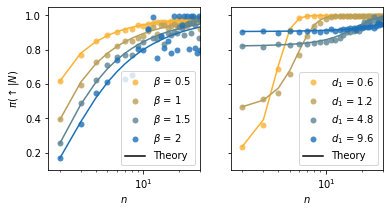

In [ ]:
fig, [ax_pw, ax_bi] = plt.subplots(1, 2, figsize = (6,3))

############# Powerlaw #################
for idx, (h, beta) in enumerate(zip(hmatrix_pw, betas)):
    if idx == 0: label = 'Theory'
    else: label = ''
    
    theory = get_ps(ps.num_states, alpha = beta, ps_0 = 1)
    ax_pw.plot(np.arange(2, num_states+1), theory[1:], c = color(idx))
    ax_pw.plot(np.arange(2, num_states+2), h[0,:]/h.sum(0), 'o', 
               c = color(idx),  label = fr'$\beta$ = {beta}', alpha = 0.8, markeredgecolor='None', lw = 0.05)

# plt.setp(ax_pw, xlim = (1.8, 30), ylim = (0.0, 1.01),
#          xlabel =r'$l$', ylabel = r'$\pi_s(l)$', 
#          yticks = np.round(np.arange(0.2, 1.01, 0.2),1),
#          yticklabels = np.round(np.arange(0.2, 1.01, 0.2),1).astype(str),
#          xscale = 'log')

ax_pw.plot(10, 10, label = 'Theory', c = 'k')   
ax_pw.legend(fontsize = font_legend)
   
    
############# BiExp #################
for idx, (lambda_1, h) in enumerate(zip(lambdas_1, hmatrix_bi)):    
    lambdas[0] = lambda_1    
    ps_composite = get_ps_composite(num_states, lambdas = lambdas, probs = probs)
    ax_bi.plot(np.arange(2, num_states+1), ps_composite[1:], '-', 
               c = color(idx))    
    ax_bi.plot(np.arange(2, num_states+2), h, 'o',               
               c = color(idx),  label = fr'$d_1$ = {np.round(lambda_1,1)}', alpha = 0.8, markeredgecolor='None')

ax_bi.plot(10, 10, label = 'Theory', c = 'k')   
ax_bi.legend(fontsize = font_legend)
    
    
plt.setp(ax_pw, xlabel =r'$n$', ylabel = r'$\pi(\uparrow|N)$', xscale = 'log')
plt.setp([ax_pw, ax_bi], xlim = (1.6, 30), ylim = (0.1, 1.049972989855765)) ;
plt.setp(ax_bi, ylabel = '', xlabel = r'$n$', yticklabels = [], xscale = 'log');


## Fig Cutoff

In [ ]:
probs = np.array([0.94, 0.06])
lambdas = np.array([0.6, 5000])
# Get theoretical policy
theory_cutoff = get_ps_composite(L = num_states, lambdas = lambdas, probs = probs)


# Setting a max step length
L_cutoffs = [30, 150, 500, 2000, 10000]

steps_og = discrete_composite_sample(lambdas = lambdas, probs = probs, L_max = num_states, num_samples = num_steps*epochs)


hmatrix_co = np.zeros((len(L_cutoffs), num_states))
for idx_c, L_cutoff in enumerate(tqdm(L_cutoffs)):
    # L_cutoff *= num_states

    steps = steps_og.copy()
    while np.max(steps) > L_cutoff:
            steps[steps > L_cutoff] = discrete_composite_sample(lambdas = lambdas, 
                                                                probs = probs,
                                                                L_max = num_states, num_samples = len(steps[steps > L_cutoff]))
    steps = steps.reshape(epochs, num_steps)
    ps = simul_2actions(num_states = num_states,
                    eta = int(1e-7),
                    gamma = 0)
    # Training
    for e in (range(epochs)):
        ps.reset()
        for s in steps[e]:         
            ps.reward(length = s)
    # Saving
    hmatrix_co[idx_c] = ps.h_matrix[0]/ps.h_matrix.sum(0)


  0%|          | 0/5 [00:00<?, ?it/s]

[Text(0.5, 0, '$n$'), Text(0, 0.5, '$\\pi(\\uparrow|N)$'), None]

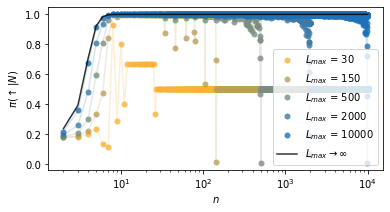

In [ ]:
fig, ax_co = plt.subplots(figsize = (6, 3))

############# Cutoff #################
for idx, (h, L_cutoff) in enumerate(zip(hmatrix_co, L_cutoffs)):   
    ax_co.plot(np.arange(2, num_states+2), h, 'o',               
               c = color(idx, num_c=5),  label = r'$L_{max}$ = '+f'{L_cutoff}', alpha = 0.8, markeredgecolor='None', rasterized=True)
    ax_co.plot(np.arange(2, num_states+2), h,                
               c = color(idx, num_c=5),  alpha = 0.2)

ax_co.plot(np.arange(2, num_states+1), theory_cutoff[1:], '-', c = 'k', alpha = 0.8, label = r'$L_{max}\rightarrow \infty$') 

plt.legend(fontsize = font_legend,  loc = 'lower right')

########### Shared ################
    
plt.setp(ax_co, xlabel =r'$n$', ylabel = r'$\pi(\uparrow|N)$', xscale = 'log')


# ax_pw.set_title('a) Power law', fontsize = font_legend)
# ax_bi.set_title('b) Bi-exponential', fontsize = font_legend)
# ax_co.set_title('Power law')

# for a, let in zip([ax_pw, ax_bi, ax_co], 'abc'):
#     a.annotate(let+')', xy = (0.02, 0.92),  fontsize = 12, xycoords = 'axes fraction') ;
    
#fig.savefig('../../../overleaf/optimal_rl/figures/fake_training_cutoff.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)